In [1]:
# Preamble: load packages
import Pkg;

Pkg.add([
    "CairoMakie",
    "VoronoiCells",
    "Images",
    "GeometryBasics",
    "ProgressMeter",
    "Interpolations",
])
using CairoMakie
using VoronoiCells, GeometryBasics
using Images, Random, Interpolations
using ProgressMeter

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
function area(polygon)
    A = 0.0
    j = length(polygon)
    for i in eachindex(polygon)
        x1,y1 = polygon[i]
        x2,y2 = polygon[j]

        A += x1*y2
        A -= y1*x2
        j = i
    end

    return A / 2
end

function centroid(polygon)
    A = 0.0
    c_x = 0.0
    c_y = 0.0

    j = length(polygon)
    for i in eachindex(polygon) 
        x1,y1 = polygon[i]
        x2,y2 = polygon[j]

        det = x1 * y2 - x2 * y1        
        A += det
        c_x += (x1 + x2) * det
        c_y += (y1 + y2) * det

        j = i
    end
    A /= 2
    return Point2([c_x, c_y] / 6A)
end

centroid (generic function with 1 method)

In [3]:
# Quick voronoi demo

# Bounding box
bbox = Rectangle(Point2(0,0), Point2(1,1))

# 10 random 2D points
Random.seed!(24)
points = Point2.(eachcol(rand(2, 10)))

# Tesselate and get the center of each cell
voro_tess = voronoicells(points, bbox)
centroids = centroid.(voro_tess.Cells);

In [4]:
# Plot the points, the centroids and the voronoi cells
function Makie.plot(points, centers, polys)
    fig, ax, scat_plot = scatter(points, color=:red, label="Point")
    cent_plot = scatter!(ax, centers, color=:blue, label="Center")
    poly_lines = nothing
    for poly in polys
        poly_lines = poly!(ax, poly, color=:transparent, strokewidth=1, srokecolor=:blue)
    end
    
    Legend(fig[1, 2], [scat_plot, cent_plot, poly_lines], ["Point", "Centroid", "Voronoi Cell"])
    hidedecorations!(ax)
    hidespines!(ax)
    return Makie.FigureAxisPlot(fig,ax,scat_plot)
end;

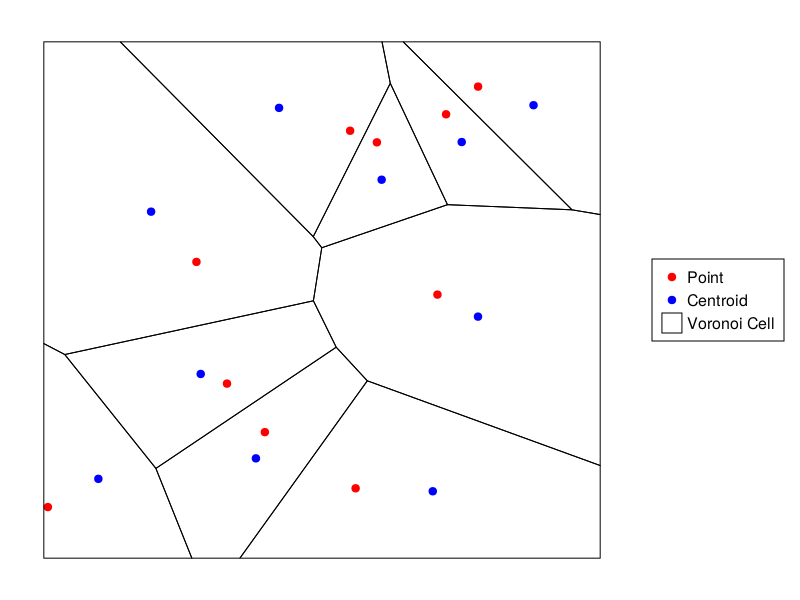

In [5]:
polys = Polygon.(voro_tess.Cells)
plot(points, centroids, polys)

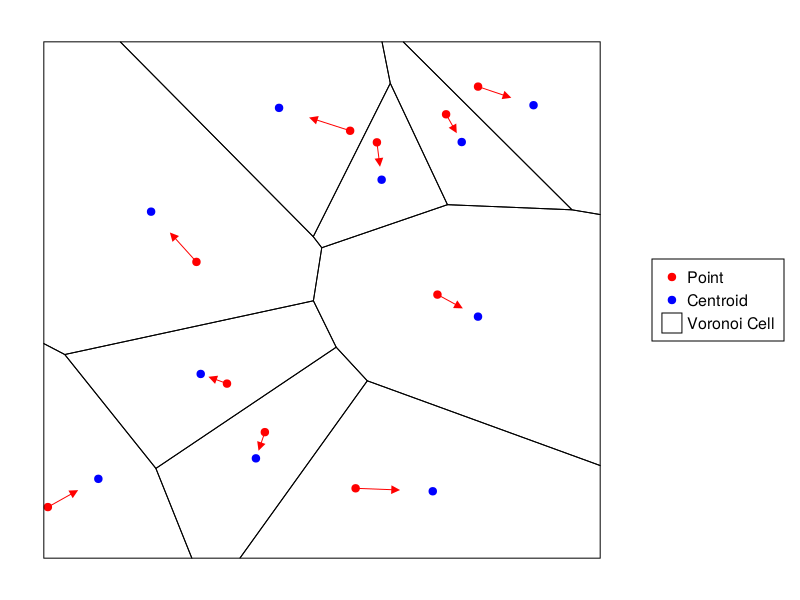

In [6]:
# Now we want to relax each point. We do this by moving each point some fraction of the way to the centroid of the cell

a = 0.5 # Fraction of the way to move
point_directions = a * (centroids .- points)

# Move the points
new_points = points .+ point_directions

# Show the movement
fig, ax, _ = plot(points, centroids, polys)

arrows!(ax, points, point_directions, color=:red, strokewidth=1)

fig

In [7]:
# Lets make the points an observable so we can redraw the plot every time we move the points
O_points = Observable(points)
O_centroids = Observable(centroids)
O_polys = Observable.(polys)

# Now simply plot the points and centroids while they are observable
fig, ax, _ = plot(O_points, O_centroids, O_polys)

lerp_size = 0.1
steps = 100
fps = 10
#Now we can loop over some relaxation steps and update the values in the observables


record(fig, "voronoi_relaxation.gif", 1:steps; framerate=fps) do frame
    # Update the points
    O_points.val = O_points.val .+ lerp_size * (O_centroids.val .- O_points.val)

    # Update the tesselation
    new_tess = voronoicells(O_points.val, bbox)
    new_tess.Cells
    # # Update the centroids and polygons
    O_centroids.val = centroid.(new_tess.Cells)

    for i in eachindex(O_polys)
        O_polys[i].val = Polygon(new_tess.Cells[i])
    end
    notify(O_points) # Redraw points
    notify(O_centroids) # Redraw centroids
end


"voronoi_relaxation.gif"

![](voronoi_relaxation.gif)

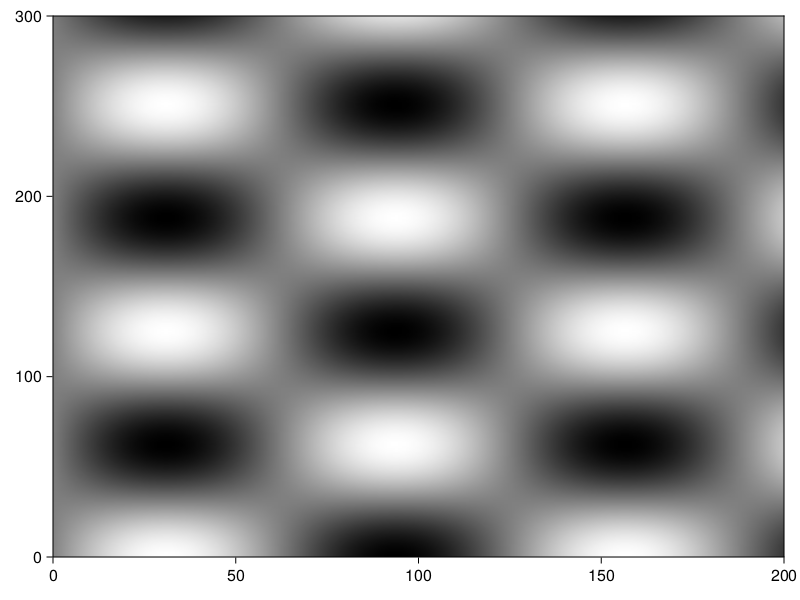

In [8]:
# Next we want to test a weighted algorithm by using the weights at each vertex

# Lets start by creating a simple test image
W, H = 200, 300;

img_F(p) = (sin(0.05p[1])*cos(0.05p[2]) + 1.0) / 2.0

img = [img_F([x, y]) for x in 1:W, y in 1:H ]

# Show image
image(img)

In [9]:
# With the data, let's create a 2D grid of points. For simplicity, we will start with a regular grid
N_points = 100
dx = W / floor(Int, sqrt(N_points))
dy = H / floor(Int, sqrt(N_points))

P = [ Point2(x,y) for x in 0:dx:W, y in 0:dy:H ]

# Crop and normalize the points
P = map(p -> p .+ Point2(dx/2, dy/2), P[1:end-1, 1:end-1])[:];

# Create a bounding box for the image
img_bbox = Rectangle(Point2(0,0), Point2(W,H))

# Tesselate the points
img_tess = voronoicells(P, img_bbox)

Tessellation{Point2{Float64}}(Point2{Float64}[[10.0, 15.0], [30.0, 15.0], [50.0, 15.0], [70.0, 15.0], [90.0, 15.0], [110.0, 15.0], [130.0, 15.0], [150.0, 15.0], [170.0, 15.0], [190.0, 15.0]  …  [10.0, 285.0], [30.0, 285.0], [50.0, 285.0], [70.0, 285.0], [90.0, 285.0], [110.0, 285.0], [130.0, 285.0], [150.0, 285.0], [170.0, 285.0], [190.0, 285.0]], Rectangle{Point2{Float64}}([0.0, 0.0], [200.0, 300.0]), Vector{Point2{Float64}}[[[0.0, 30.000000000000078], [0.0, 0.0], [19.99999999999992, 0.0], [20.000000000000117, 30.000000000000078], [19.99999999999992, 30.000000000000078]], [[19.99999999999992, 30.000000000000078], [19.99999999999992, 0.0], [40.000000000000036, 0.0], [40.000000000000036, 30.000000000000078]], [[40.000000000000036, 30.000000000000078], [40.000000000000036, 0.0], [59.99999999999996, 0.0], [59.99999999999996, 30.000000000000078]], [[59.99999999999996, 30.000000000000078], [59.99999999999996, 0.0], [80.00000000000027, 0.0], [80.00000000000007, 30.000000000000078]], [[80.000

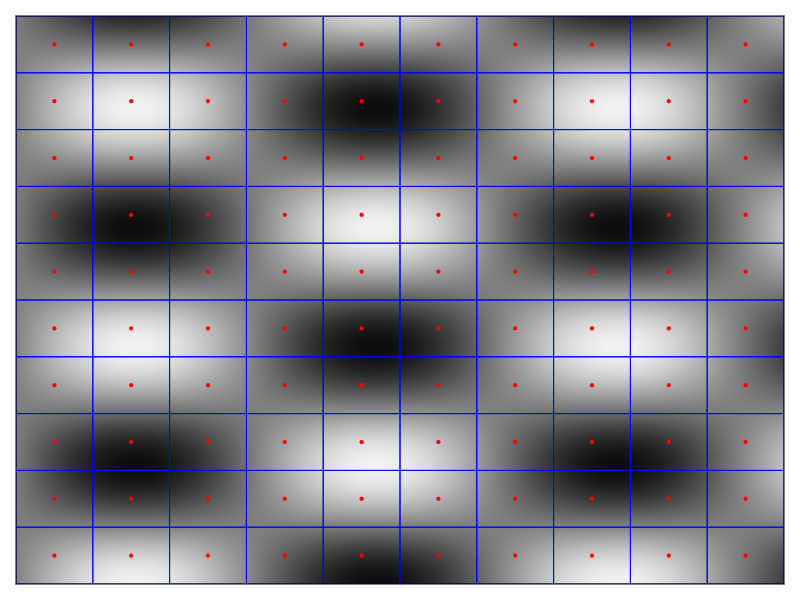

In [10]:
# And visualize points

fig = Figure()
ax = Makie.Axis(fig[1,1])
hidedecorations!(ax)

# Get polys
img_polys = Polygon.(img_tess.Cells)

img_plot = image!(ax, img, colormap=:grays)
scat_plot = scatter!(ax, P, color=:red, markersize=6)
poly_plot = poly!.(Ref(ax), img_polys, color=:transparent, strokewidth=1, strokecolor=:blue)

fig

In [11]:
# Now, lets implement a function that calculates the centroid but is weighted by the data at each point

function weighted_direction(polygon, weights)
    center = centroid(polygon)
    
    # Get a vector from center to each vertex in polygon
    vert_dir = map(p -> p .- center, polygon) .* weights

    # Lastly, move the center by the sum of the vectors
    return vert_dir
end

function weighted_centroid(polygon, weights) 
    center = centroid(polygon)
    vert_dir = map(p -> p .- center, polygon) .* weights
    return center + sum(vert_dir)
end

crop_centroid(center, bbox) = Point2(min(max(center[1], bbox.LowerLeft[1]), bbox.UpperRight[1]), min(max(center[2], bbox.LowerLeft[2]), bbox.UpperRight[2]))

crop_centroid (generic function with 1 method)

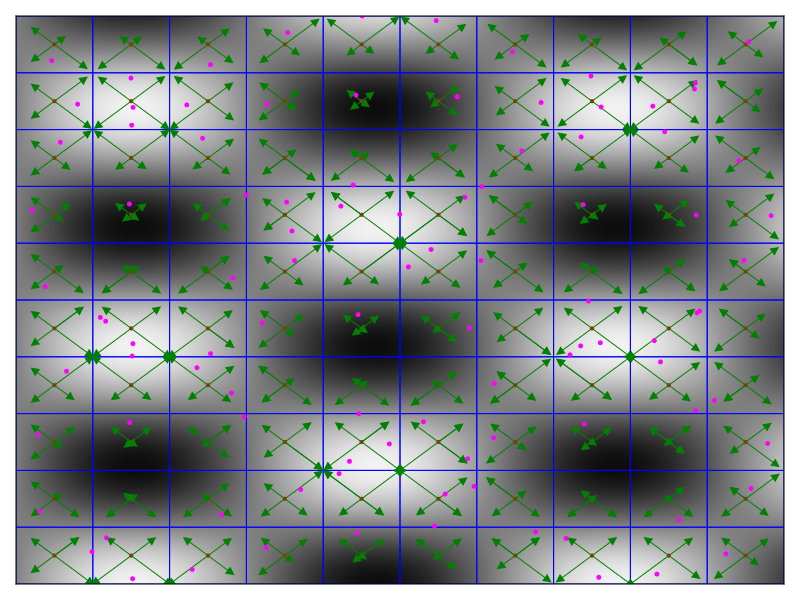

In [12]:
# Lets visualize it

# Start by getting the weights at each vertex, and then calculate the weighted centroid
dirs = weighted_direction.(img_tess.Cells, [img_F.(P) for P in img_tess.Cells])

# new_centers = [p + sum(d) for (p,d) in zip(P, dirs)] .|> (p -> crop_centroid(p, img_bbox))
new_centers = weighted_centroid.(img_tess.Cells, [img_F.(P) for P in img_tess.Cells]) .|> (p -> crop_centroid(p, img_bbox))

fig = Figure()
ax = Makie.Axis(fig[1,1])
hidedecorations!(ax)

# Get polys
img_polys = Polygon.(img_tess.Cells)

img_plot = image!(ax, img, colormap=:grays)
scat_plot = scatter!(ax, P, color=:red, markersize=6)
poly_plot = poly!.(Ref(ax), img_polys, color=:transparent, strokewidth=1, strokecolor=:blue)

# Add the weighted centroids
for i in eachindex(dirs)
    for j in eachindex(dirs[i])
        arrows!(ax, P[i,:], dirs[i][j,:], color=:green, strokewidth=1)
    end
end

scatter!(ax, new_centers, color=:magenta, markersize=7)

fig

In [15]:
# Now lets iterate over this and see how the weighted centroid moves the points in accordance to the underlying data 

# Observables of the seed points 
O_P = Observable(P)

# Observables of the weighted centroids
O_centers = Observable(new_centers)

# Observables of the polygons
O_polys = Observable.(img_polys)

# Now simply plot the points and centroids while they are observable
fig, ax, _ = plot(O_P, O_centers, O_polys)
img_plot = image!(ax, img, colormap=:grays, alpha=0.4)

lerp_size = 0.1
steps = 100
fps = 10
#Now we can loop over some relaxation steps and update the values in the observables


record(fig, "voronoi_vert_weight_relaxation.gif", 1:steps; framerate=fps) do frame
    # Update the points
    O_P.val = O_P.val .+ lerp_size * (O_centers.val .- O_P.val)

    # Update the tesselation
    new_tess = voronoicells(O_P.val, img_bbox)
    new_tess.Cells
    # Update the centroids based on the weight for each new vertex
    O_centers.val = weighted_centroid.(new_tess.Cells, [img_F.(P) for P in new_tess.Cells]) .|>
        (c -> crop_centroid(c, img_bbox))

    for i in eachindex(O_polys)
        O_polys[i].val = Polygon(new_tess.Cells[i])
    end
    notify(O_P) # Redraw points
    notify(O_centers) # Redraw centroids
end

"voronoi_vert_weight_relaxation.gif"

![](voronoi_vert_weight_relaxation.gif)